# Digital Earth Australia Fractional Cover <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 

## Description

This notebook will demonstrate how to load data from the DEA Fractional Cover product using the Digital Earth Australia datacube. 
Topics covered include:

* A brief overview of the DEA Fractional Cover product
* Loading data from DEA Fractional Cover into a notebook for further analysis

***


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [23]:
import sys
import datacube
from datacube.utils.masking import mask_invalid_data

sys.path.append("../Scripts")
from dea_metadata import cmi_metadata

# Connect to the datacube
dc = datacube.Datacube(app='DEA_Fractional_Cover')

# This line of code automatically loads the latest product metadata
cmi_metadata("DEA Fractional Cover")

## DEA Fractional Cover
### Background
<p>Fractional cover data can be used to identify large scale patterns and trends and inform evidence based decision making and policy on topics including wind and water erosion risk, soil carbon dynamics, land management practices and rangeland condition.</p>

<p>This information is used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time frames.</p>

### What this product offers
<p>Fractional Cover (FC), developed by the Joint Remote Sensing Research Program, is a measurement that splits the landscape into three parts, or fractions:</p>

<ul><li>green (leaves, grass, and growing crops)</li>
	<li>brown (branches, dry grass or hay, and dead leaf litter)</li>
	<li>bare ground (soil or rock)</li>
</ul><p>DEA uses Fractional Cover to characterise every 25 m square of Australia for any point in time from 1987 to today.</p>

### Applications
<p>Fractional cover provides valuable information for a range of environmental and agricultural applications, including:</p>

<ul><li>soil erosion monitoring</li>
	<li>land surface process modelling</li>
	<li>land management practices (e.g. crop rotation, stubble management, rangeland management)</li>
	<li>vegetation studies</li>
	<li>fuel load estimation</li>
	<li>ecosystem modelling</li>
	<li>land cover mapping</li>
</ul>



> **Note:** For more technical information about the DEA Fractional Cover product, visit the official [Geoscience Australia DEA Fractional Cover product description.](https://cmi.ga.gov.au/data-products/dea/119/dea-fractional-cover-landsat)

<img align="left" src="https://cmi.ga.gov.au/sites/default/files/2020-08/FractionalCover1.jpg" width="250" style="padding-left: 20px;">

## Loading DEA Fractional Cover data

### Data structure and available measurements (bands)

We can use the datacube `dc.list_measurements()` method to explore the measurement variables (bands) that are available in the data. 
We will inspect the Landsat 8 version of the DEA Fractional Cover product (`ls8_fc_albers`); for Landsat 5 and 7 use `ls5_fc_albers` and `ls7_fc_albers` respectively.

> **Note:** For more information about inspecting product measurements using `datacube`, refer to the [Products and Measurements notebook](../Beginners_guide/03_Products_and_measurements.ipynb).


In [16]:
product = 'ls8_fc_albers'
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
BS,BS,int16,percent,-1,[bare],NaN,NaN
PV,PV,int16,percent,-1,[green_veg],NaN,NaN
NPV,NPV,int16,percent,-1,[dead_veg],NaN,NaN
UE,UE,int16,1,-1,[err],NaN,NaN


The DEA Fractional Cover product consists of four data layers:

1. The fractional cover of green vegetation (PV) 
2. The fractional cover of non-green vegetation (NPV)
3. The fractional cover of bare soil (BS)
4. The fractional cover unmixing error (UE)

The values for this product are scaled as follows:
* For the fractional cover bands (PV, NPV, BS)
* 0-100 = fractional cover values that range between 0 and 100%

Due to model uncertainties and the limitations of the training data, some areas may show cover values in excess of 100%.  These areas can either be excluded or treated as equivalent to 100%. 
For the unmixing error (UE) band, the values are scaled between 0 and 127.
High unmixing error values represent areas of high model uncertainty (areas of water, cloud, cloud shadow or soil types/colours that were not included in the model training data). 


### Loading data
We can use the datacube `dc.load()` function to load DEA Fractional Cover data.
At minimum, the following information needs to be provided: 
* The product name (e.g. `ls8_fc_albers`)
* An `x` and `y` extent 
* A `time` period 
* A `group_by` parameter that ensures that all images taken by the satellite on a single day are combined into a single observation.

> **Note:** For more information about loading data using `datacube`, refer to the [Loading data notebook](../Beginners_guide/04_Loading_data.ipynb).


In [17]:
fc_ds = dc.load(product='ls8_fc_albers',
                x=(153.18, 153.38),
                y=(-29.35, -29.55),
                time=("2018-01-01", "2018-01-20"),
                group_by="solar_day")

In [18]:
print(fc_ds)

<xarray.Dataset>
Dimensions:      (time: 3, x: 906, y: 1013)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T23:42:39 ... 2018-01-19T23:...
  * y            (y) float64 -3.359e+06 -3.359e+06 ... -3.384e+06 -3.384e+06
  * x            (x) float64 2.02e+06 2.02e+06 2.02e+06 ... 2.042e+06 2.042e+06
    spatial_ref  int32 3577
Data variables:
    BS           (time, y, x) int16 0 0 10 6 0 0 15 32 ... 40 36 38 38 44 39 35
    PV           (time, y, x) int16 89 80 72 78 82 87 70 ... 9 10 11 12 15 15 16
    NPV          (time, y, x) int16 10 20 17 15 18 12 14 ... 55 50 50 42 46 49
    UE           (time, y, x) int16 43 41 36 37 41 43 36 ... 22 23 23 25 26 27
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Setting nodata to `NaN`

In [25]:
fc_ds = mask_invalid_data(fc_ds)
print(fc_ds)

<xarray.Dataset>
Dimensions:      (time: 3, x: 906, y: 1013)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T23:42:39 ... 2018-01-19T23:...
  * y            (y) float64 -3.359e+06 -3.359e+06 ... -3.384e+06 -3.384e+06
  * x            (x) float64 2.02e+06 2.02e+06 2.02e+06 ... 2.042e+06 2.042e+06
    spatial_ref  int32 3577
Data variables:
    BS           (time, y, x) float64 0.0 0.0 10.0 6.0 ... 38.0 44.0 39.0 35.0
    PV           (time, y, x) float64 89.0 80.0 72.0 78.0 ... 15.0 15.0 16.0
    NPV          (time, y, x) float64 10.0 20.0 17.0 15.0 ... 42.0 46.0 49.0
    UE           (time, y, x) float64 43.0 41.0 36.0 37.0 ... 25.0 26.0 27.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Plotting data

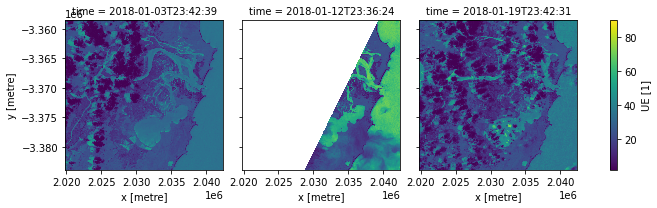

In [27]:
fc_ds.UE.plot(col='time')

In [ ]:
fc_ds.PV

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)